In [1]:
import argparse
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import os
from pathlib import Path
from time import sleep
from random import random
from multiprocessing import Pool
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.ops import transform
from descartes import PolygonPatch
import networkx as nx
from mpl_toolkits import mplot3d
import settings
import base as cylinder
import copy
import math
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'

In [2]:
#alpha shape / concave hull
from shapely.ops import cascaded_union, polygonize,  Point,Polygon
import shapely.geometry as geometry
from scipy.spatial import Delaunay
import numpy as np
import math
def concave_hull(boundary_points, alpha):
    #Draws the minimal concave polygon with a concavity  factor alpha 
    if len(boundary_points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(boundary_points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        #adds a line between points i and j
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in boundary_points])

    #Minimal set of triangles with points in set
    tri = Delaunay(coords)

    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return unary_union(triangles), edge_points

In [3]:
#Read_file_names
def read_file_names():
    os.chdir(''.join([DIR,'input']))
    fullPath = Path(''.join([DIR,'input']))
    paths = sorted(fullPath.iterdir(),key=os.path.getmtime)
    fileNames = [f.name for f in paths if  f.suffix == '.csv' ]
    print(fileNames)
    return fileNames

In [4]:
#CC class
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import logging
import settings
import os
from pathlib import Path
from time import sleep
from random import random
from multiprocessing import Pool
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from descartes import PolygonPatch
import networkx as nx
from mpl_toolkits import mplot3d
from pickle import dump, load
from stemPath import StemPath

import openpyxl
import calendar
import time
import copy

current_GMT = time.gmtime()
time_stamp = str(calendar.timegm(current_GMT))

NAME = "Cylinder"
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'
logging.basicConfig(filename=''.join(['log_',str(time_stamp)])  , filemode='w', level=logging.DEBUG)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))
log = logging.getLogger("my-logger")
#suggested libraries 
#import pytest as pt
#import logging as log # replace writes to the console with various logging 
class CylinderCollection:
    
    #initialize our object level variables for cylider objects 
    def __init__(self, filename) -> None:
        self.filename = filename
        self.x = np.nan
        self.y = np.nan
        self.z = np.nan
        self.radius = np.nan
        self.noCylinders = np.nan
        self.cLength = np.nan
        self.BO = np.nan
        self.maxBO = np.nan
        self.dx = np.nan
        self.dy = np.nan
        self.dz = np.nan
        self.theta = np.nan
        self.pID = np.nan
        self.pSV = []
        self.df_full = pd.DataFrame()
        self.df = pd.DataFrame()
        self.total_union = None
        self.stem_path_lengths = np.nan
        self.graph = nx.Graph()
        self.bID = np.nan
        self.stem_paths =  []
        self.dripPoints = []
        self.dividePoints = []
        self.rev =None
        self.aV=pd.DataFrame()
        self.bV=pd.DataFrame()
        self.stemPaths=pd.DataFrame()
        self.flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
        self.flow_to_drip = {0:1} # A dictionary of flow ids with values equal to their drip node ids 
        self.trunkNodes = []
        self.drip_loc = np.nan
        self.treeQualities  = pd.DataFrame({'total_psa':-1 ,'tot_hull_area':-1, 'stem_flow_hull_area':-1 ,'stem_psa':-1 ,'flowStats':-1 ,'DBH':-1},index=[0])
        self.stemTotal = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0}, index = [0])
        self.dripTotal = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0}, index = [0])
        self.flowAgg = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0, 'type':''}, index = [0])
        self.dividePolys = []
        self.stemPolys = []
        self.compGraphs = []

    
    def save_file(self, toWrite = [], subdir:str = 'agg', fileFormat ='.png',method=''):
        proj = 'XY'
        if self.rev : 
            proj='XZ'
        file_arr = os.path.splitext(os.path.basename(self.filename))
        dir = '/'.join([self.output_dir, method, '']).replace('/','\\')
        ofname = '_'.join([file_arr[0], method, proj , fileFormat ]).replace('/','\\')
        aggname = '_'.join(['agg', method, proj , fileFormat ]).replace('/','\\')
        folderExists = os.path.exists(dir)
        fileExists = os.path.exists(dir+ofname)
        aggExists = os.path.exists(dir+aggname)
        if not folderExists:
            os.makedirs(dir)
        if fileFormat =='.png': 
            plt.savefig(dir+ofname, format='png', dpi=1200)
        else:
            if not fileExists:
                with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
            else:
                exist = pd.read_excel(open(dir+ofname, 'rb'), sheet_name=method, engine = 'openpyxl')  
                toWrite = toWrite.append(exist)
                with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
            if not aggExists:
                with pd.ExcelWriter(dir + aggname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)    
            else:
                exist = pd.read_excel(open(dir+aggname, 'rb'), sheet_name=method, engine = 'openpyxl')  
                toWrite = toWrite.append(exist)
                with pd.ExcelWriter(dir + aggname, engine = 'openpyxl',mode='w') as writer:
                    toWrite.to_excel(writer, index = False, sheet_name =method)
    
    def load_stem_paths(self):  
        self.stempaths = np.load(''.join([DIR,'output/stems/',str(self.filename),'.npy']))

    def load_graph(self):
        gname =  str(''.join([DIR,'output/graphs/', self.filename.replace('.csv','.txt')]))
        with open(gname, 'rb') as file :
            self.graph = nx.read_gpickle(gname)
 
    def read_csv(self,df = pd.DataFrame(), polys = [],rev=False):
        #Columns [ID?,ParentID?,x1,y1,z1,x2,y2,z2,radius,?,?,lenght,? ,? ,? ,? ,? ,? ,? ,BO]
        #Colnums [1  ,2        ,3 , 4, 5, 6, 7, 8,9    ,10,11,12   ,13,14,15,16,17,18,19,20]
        # x = x2-x1, y =y2-y1, z=z2-z1
        #number of cyliders = cnt values for radius
        # Theta  = angle made buy the cylinder axis
        self.rev =rev 
        if('partial' not in self.filename):
            self.df_full = pd.read_csv(self.filename,header=0)
        else: 
            self.df_full = df
        self.maxBO = np.max(self.BO)
        #self.df = self.df_full 
        self.df=self.df_full#.iloc[:130,:]
        self.x = np.transpose(self.df.iloc[:,[3,6]].to_numpy())#columns 3 and 6 represent our x values
        if rev:
            self.z = np.transpose(self.df.iloc[:,[4,7]].to_numpy())#columns 4 and 7 the y values 
            self.y = np.transpose(self.df.iloc[:,[5,8]].to_numpy())#columns 5 and 8 the z values 
        else:    
            self.y = np.transpose(self.df.iloc[:,[4,7]].to_numpy())#columns 4 and 7 the y values 
            self.z = np.transpose(self.df.iloc[:,[5,8]].to_numpy())#columns 5 and 8 the z values 
        # for side view
        self.rev = rev
        self.cylID = self.df.iloc[:,1].to_numpy()
        self.pID =self.df.iloc[:,2].to_numpy()
        self.radius = self.df.iloc[:,9].to_numpy()
        self.noCylinders = self.radius.size
        self.cLength = self.df.iloc[:,12].to_numpy()
        self.BO = self.df.iloc[:,20].to_numpy()
        self.maxBO = np.max(self.BO)
        self.bID = self.df.iloc[:,24].to_numpy()
        self.dx = self.df.iloc[:,6].to_numpy() - self.df.iloc[:,3].to_numpy()
        self.dy = self.df.iloc[:,7].to_numpy() - self.df.iloc[:,4].to_numpy()
        self.dz = self.df.iloc[:,8].to_numpy() - self.df.iloc[:,5].to_numpy()
        if('partial' in self.filename): self.pSV = polys
        self.theta = np.arctan(self.dz/np.sqrt(self.dx**2 + self.dy**2))
        self.output_dir = ''.join([DIR,'output/'])
        log.info(self.filename + " initialized")
    
    def create_wdgraph(self):
        R = {}
        sid = self.df[' ID']
        pid = self.df[' parentID']
        sid.min()
        sid = sid + 1
        pid = pid + 1

        noSeg = np.max(sid) + 2
        #A = np.zeros((noSeg,noSeg))
        
        #color = iter(cm.rainbow(np.linspace(0, 1, noSeg)))
        
        attr = []
        gr = nx.Graph()
        for idx in range(noSeg-3):
            #print a progress update once every 10 thousand or so cylinders
            if np.random.uniform(0,1,1) < 0.0001:
                log.info(self.filename + ':  wdgraph - adding edge  {} \n'.format(np.round((idx/noSeg)*100,decimals=1)))
                print('wdgraph - adding edges completed {} \n'.format(np.round((idx/noSeg)*100,decimals=1)))
            #from row to column
            child =sid[idx]
            par = pid[idx]
            # attr={"length" : self.df.iloc[pid[idx], 12],
            #         "bheight": self.df.iloc[pid[idx], 5],
            #         "eheight": self.df.iloc[pid[idx], 8],
            #         "radius": self.df.iloc[pid[idx], 9],
            #         "aV": self.aV[pid[idx]],
            #         "bV": self.bV[pid[idx]],
            #         "bV": self.bV[pid[idx]]
            #         }
            run = (math.sqrt(self.dx[sid[idx]-1]*self.dx[sid[idx]-1] + self.dy[sid[idx]-1]*self.dy[sid[idx]-1]))
            if run==0:
                inFlowGrade = 1 # straightDown e.g. is in flow 
            else:
                inFlowGrade = self.dz[sid[idx]-1]/run
            gr.add_edge(child,par,length= self.df.iloc[sid[idx]-1, 12],
                                  radius= self.df.iloc[sid[idx]-1, 9],
                                  aV= self.aV[sid[idx]-1],
                                  poly= self.pSV[sid[idx]-1],
                                  inFlowGrade = inFlowGrade
                                  )  
        self.graph = gr

    #its pro-ject not prah-ject
    def project_cylinders(self):
        log.info(self.filename + " cylinder projection begun")
        noCirPoints = 360
        
        tCir = np.linspace(0,2*np.pi,noCirPoints) #360 evenly spaced points between 0 - 2pi (radian degrees)

        XOrtho = np.cos(tCir)
        YOrtho = np.sin(tCir)

        #unit vector at base of cylinder, pointing up cylinder axis
        vNorm = (np.sqrt(self.dx**2+self.dy**2+self.dz**2))
        aV = np.hstack((self.dx[:,None],self.dy[:,None],self.dz[:,None]))/vNorm[:,None]
        bV = -aV; #unit vector looking down from top circle (but not translated)
        self.aV = aV
        self.bV = bV
        #function to find orthgonal vectors
        oVz = lambda v,x,y : ((-v[0]*x - v[1]*y)/v[2])

        #initializing min max arrays+
        minZ = np.zeros_like(self.dz)
        maxZ = np.zeros_like(self.dz)

        pSV = [None]*self.noCylinders

        #for each cylinder
        for idx in range(self.noCylinders):

            #in the case there's no horizontal movement of the cylinder ends, it's
            #area is a circle.
            if not np.isnan(self.x[0,idx]):
                if np.logical_and(self.dx[idx] == 0, self.dy[idx] == 0):
            
                    pX = self.x[0,idx] + self.radius[idx]*XOrtho
                    pY = self.y[0,idx] + self.radius[idx]*YOrtho
                    cPS = Polygon(list(zip(pX,pY)))
                    minZ[idx] = np.min(self.z[:,idx])
                    maxZ[idx] = np.max(self.z[:,idx])
                else:
                    #find orthogonal vectors @ endpoints
                    aVp1 = np.hstack((aV[idx,1],-aV[idx,0]))
                    aVp2 = np.hstack((-aV[idx,1],aV[idx,0]))
                    bVp1 = np.hstack((bV[idx,1],-bV[idx,0]))
                    bVp2 = np.hstack((-bV[idx,1],bV[idx,0]))
                
                    aVp1 = aVp1/np.linalg.norm(aVp1)
                    aVp2 = aVp2/np.linalg.norm(aVp2)
                    bVp1 = bVp1/np.linalg.norm(bVp1)
                    bVp2 = bVp2/np.linalg.norm(bVp2)
                
                    #from each endpoint, use radius to find vertices of the rectangle
                    x1 = self.x[0,idx] + self.radius[idx]*aVp1[0]
                    y1 = self.y[0,idx] + self.radius[idx]*aVp1[1]
                    x2 = self.x[0,idx] + self.radius[idx]*aVp2[0]
                    y2 = self.y[0,idx] + self.radius[idx]*aVp2[1]  
                    x3 = self.x[1,idx] + self.radius[idx]*bVp1[0]
                    y3 = self.y[1,idx] + self.radius[idx]*bVp1[1]
                    x4 = self.x[1,idx] + self.radius[idx]*bVp2[0]
                    y4 = self.y[1,idx] + self.radius[idx]*bVp2[1]
            
            
                    #calculate set of orthgonal vectors using lambda function
                    ZOrtho = oVz(aV[idx,:],XOrtho,YOrtho)
                
                    #unit-ify the orthgonal vectors
                    uovd = np.sqrt(XOrtho**2 + YOrtho**2 + ZOrtho**2)
                    uov = np.hstack((XOrtho[:,None],YOrtho[:,None],ZOrtho[:,None]))/uovd[:,None]
            
                    #donot re unit-fy, you only want the horizontal component, not the
                    #renormalized horizontal component
                
                    #using only the X and Y components, find circle coods in plane of
                    #interest
                    xaC = self.x[0,idx] + uov[:,0]*self.radius[idx]
                    yaC = self.y[0,idx] + uov[:,1]*self.radius[idx]
                    zaC = self.z[0,idx] + uov[:,2]*self.radius[idx]
            
                    xbC = self.x[1,idx] + uov[:,0]*self.radius[idx]
                    ybC = self.y[1,idx] + uov[:,1]*self.radius[idx]
                    zbC = self.z[1,idx] + uov[:,2]*self.radius[idx]
            
                    minZ[idx] = np.min(np.vstack((zaC, zbC)))
                    maxZ[idx] = np.max(np.vstack((zaC, zbC)))
                
                    #assymble total package
                    rX = np.vstack((x1, x2, x3, x4))
                    rY = np.vstack((y1, y2, y3, y4))
            
                    #test for circle parts in polygon
                    c1 = Polygon(list(zip(xaC,yaC)))
                    bBox = Polygon(list(zip(rX,rY)))
                    c2 = Polygon(list(zip(xbC,ybC)))           
                    partsPS = [c1,bBox,c2]
            
                    try: 
                        cPS = unary_union(partsPS)
                    except:
                        print(np.any(np.isnan(xaC)))
                        print(yaC)
                        print(rX)
                        print(rY)
                        print(xbC)
                        print(ybC)
                #cPS = cPS.simplify(0.02,preserve_topology=False)               
                self.pSV.append(cPS) #save polygons
                            
                #print a progress update once every 10 thousand or so cylinders
                if np.random.uniform(0,1,1) < 0.0001:
                    log.info(self.filename + ': completed projection of cyl {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
                    print('completed cyl projection {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))

    def highlight_branch_order(self, bo):
        trunk_ids = []
        colors = ['']*len(self.pSV)
        rev_polys =['']*len(self.pSV)
        for idx, bo_i in enumerate(self.BO):
            if np.random.uniform(0,1,1) < 0.0001:
                log.info(self.filename + ': completed coloring BO {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
                print('completed coloring BO {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
            if bo_i == bo: 
                trunk_ids.append(idx)
                colors[-idx] = 'Red'
                #polys.append(c.pSV[idx])
            else:
                colors[-idx] ='None'
            rev_polys[-idx] = self.pSV[idx]

        fig, ax = plt.subplots() 
        myPolys = geo.GeoSeries(rev_polys)
        myPolys.plot(color=colors,ax=ax, alpha = .5)
        if self.rev :
            self.save_file(method = 'BO_highlight' )    
        else: 
            self.save_file(method = 'BO_highlight' )    
        plt.ion()
        plt.show() 
        plt.close()        
    
    def find_flows(self, inFlowGradeLim = -1/6, severeAngleLim=6.3,filt=[] ):#severeAngleLim defaults to >2pi, 
        c= self
        g = c.graph
        if filt ==[]:
            gfilt =copy.deepcopy(g)  
            trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
            self.trunkNodes =trunkNodes
        else:
            gfilt = copy.deepcopy(nx.induced_subgraph(g,filt))
            trunkNodes =  np.intersect1d(np.where(c.BO == 0 )[0],filt)  +1#node_id is cyl_id +1 as cyl 0 has parent -1 
            
        gtest = nx.Graph(copy.deepcopy(gfilt))
        self.trunkNodes=trunkNodes 
        gtest = copy.deepcopy(gfilt)
        inFlowDef = 'inFlowGrade'
        #Set attributes used to mark drip point and flows
        nx.set_edge_attributes(g, np.nan, 'flowType') 
        nx.set_edge_attributes(g, np.nan, 'flowID')
        nx.set_edge_attributes(g, np.nan, 'dripNode')
        nx.set_node_attributes(g, np.nan, 'flowType')
        nx.set_node_attributes(g, np.nan, 'isDripPoint')
        nx.set_node_attributes(g, np.nan, 'isDividePoint')
        #function to get angles of unit vectors 
        get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])  
        flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
        trunk_flow = pd.DataFrame({ 'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
        prev_node = None
        trunk_edges = []
        for n in trunkNodes:
            if prev_node !=None:
                trunk_edges.append((prev_node,n))
                g.nodes[n]['flowType'] = 'stem'
            else:
                trunk_edges.append((1,0))
                g.nodes[0]['flowType'] = 'stem' 
            prev_node = n
        for te in trunk_edges:
            g.edges[te]['flowID'] = 0
            g.edges[te]['flowType'] = 'stem' 
        non_trunk_edges = [e for e in gfilt.edges(trunkNodes) if e not in trunk_edges]
        flows = pd.concat([flows, trunk_flow], ignore_index=True)
        gtest.remove_nodes_from(trunkNodes)
        gtest.add_edges_from(non_trunk_edges) 
        #print(nx.number_connected_components(gtest))
        titans = [node for node in gtest.nodes if (nx.degree(gfilt,node)!=nx.degree(gtest,node))]
            #Nodes with a parent node in trunk, only 1 per connected component
        c.connComps = nx.connected_components(gtest)
        compGraphs = [g.subgraph(comp).copy() for comp in c.connComps]
        self.compGraphs =compGraphs
        #
        flow_to_drip = { 0:(1,'stem') }# flow_path_id:(node_id,flow_type); the flow on the trunk is always flow_path_id 0 and has drip point node 1
        # if 1==1:
            # compGraph = compGraphs[16]# for testing
            # test = True
        for comp_id,compGraph in enumerate(compGraphs): #suenumerate(c.connComps):
            if np.random.uniform(0,1,1) < 0.1:
                log.info(self.filename + ': flows  {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
                print('completed flows {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
            test = False
            if test : print('comp_id: '+str(comp_id))
            #compGraph = g.bgraph(comp).copy()
            nodes = compGraph.nodes()
            # myPolys = []
            # for n in nodes:
            #     myPolys.append(c.pSV[n-1])
            
            endnodes = [e for e in compGraph.nodes if compGraph.degree(e)==1]
            root =list(set(titans) & set(compGraph.nodes)) #get root of connected component
            if root[0] in endnodes: endnodes.remove(root[0])
            sp = nx.shortest_path(compGraph,target=root[0])
            sp_endNode_paths = [path for path in sp.values() if path[0] in endnodes]
            # stem flow is always id 0
            # print('stem flow added :' + str(flows))
            #arrays we are using are all unit arrays and we want angles with x,y and z ([1,0,0],[0,1,0] and [0,0,1])
            # display(flows)
            for path in sp_endNode_paths:
                # print('path ' + str( path))
                traversedEdges = []
                flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                    }, index = [0])
                angleSum=0
                angles = [0,0,0]
                prev_angles = [0,0,0]
                current_dp_node = 0 # add convenience var 'in inflow v in out flow '
                if test : print(path)
                for idx,n in enumerate(path):  
                    if test : print('Entering path Loop ' + str(idx) + ' for node '  + str(n) + ' next node ' + str(path[idx+1])) 
                    if test : print('dtf: '+str(flow_to_drip))
                    if test : print('next node '  + str(path[idx+1])) 
                    if test : print('current_dp_node'  + str(current_dp_node)) 
                    node_id = n
                    next_node_id  = path[idx+1]
                    node = g.nodes[node_id]
                    next_node =  g.nodes[next_node_id]
                    edge = g.edges[node_id,next_node_id]
                    if test : print('edge[''inFlow''] '  + str(edge[inFlowDef]>inFlowGradeLim)) 
                    if test : print('edge[''len''] '  + str(edge['length'])) 
                    curr_angles = get_angle_array(edge['aV'])
                    angleSum += curr_angles.iloc[3]  
                    traversedEdges.append((node_id,next_node_id)) # add node to list of nodes in this path 
                    flow['cyls']+=1
                    flow['len'] +=edge['length']
                    flow['sa'] +=2*np.pi*edge['radius']*(edge['radius'] +edge['length'])
                    flow['pa'] +=edge['poly'].area
                    if test : print('flow: ' + str(flow))
                    if test : print('flows: ' + str(flows))
                    if idx+2==len(path):#*perhaps we change this to say 'if the next node is the root', for simplicity 
                        # print('last run entered')
                        #then path[idx+1] is the root node -> edge is last edge
                        if current_dp_node!= 0:
                            if edge[inFlowDef]>inFlowGradeLim:
                                #not possible as we would have had to set current_dp_node last loop 
                                # we would onlt do so if this edge had out flow
                                if test : print('Error: Reached last edge and edge has inflow and is in drip path')
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + 'stem')
                                flow_to_drip[flow_id] = (current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                traversedEdges = [] # reset array'
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                break
                            #Then we are on a drip path 
                            elif edge[inFlowDef]<=inFlowGradeLim:
                                #then we do indeed add this last cyl to the drip flow
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + str(flowType))
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                if test : print('path.index(current_dp_node): ' + str(path.index(current_dp_node)))
                                if test : print('pathLen ' + str(len(path)))
                                if test : print('current_dp_node: ' + str(current_dp_node))
                                traversedEdges = [] # reset array'
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                if test : print('New drip Flow Created (last node ) ' +str(flow_id))
                                break
                        elif edge[inFlowDef]>inFlowGradeLim: #must be the case given current_dp_node ==0
                            # edge contribures to stem flow 
                            if test : print('flow to add: '+str(flow))
                            flows = pd.concat([flows, flow], ignore_index=True)
                            flow_id = len(flows.index)-1
                            flowType = 'stem'
                            for traversedEdge in traversedEdges: 
                                g.edges[traversedEdge]['flowID'] = flow_id
                                g.edges[traversedEdge]['flowType'] = flowType
                                if test : print(str(traversedEdge) + 'marked stem')
                            flow_to_drip[flow_id] = (next_node_id,flowType)
                            g.nodes[next_node_id]['flowType'] = flowType
                            traversedEdges = [] # reset array'
                            current_dp_node = 0
                            flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                    }, index = [0])
                            if test : print('New stem flow added ' +str(flow_id))
                            if test : print('flows: ' + str(flows))
                        break
                    elif idx+2<len(path):
                        next_next_node_id = path[idx+2]
                        if test : print('next_next_node_id' + str(next_next_node_id)) 
                        next_next_node =  g.nodes[next_next_node_id]
                        next_edge = g.edges[next_node_id,next_next_node_id]
                        next_angles = get_angle_array(next_edge['aV'])
                        angle_diffs = curr_angles - next_angles
                        severe_angle_change = angle_diffs.iloc[3][0]>(severeAngleLim )
                            
                        if current_dp_node!=0:
                            if next_edge[inFlowDef]>inFlowGradeLim:#curr edge is last in flow
                                #add new flow, reset vars
                                next_next_node['isDividePoint'] = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                next_node['isDripPoint'] = True
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                current_dp_node = 0
                                if test : print('New drip Flow Created (divide reached) ' +str(next_next_node_id))
                                if test : print('traversedEdge: ' + str(traversedEdge))
                                continue
                                
                            if ~np.isnan(next_edge['flowID']):
                                # we might siphon some flow off from the intercepted path here, but we ignore this possibility for simplicity 
                                if next_edge[inFlowDef]<=inFlowGradeLim: 
                                    #*****Here we have a drip path stemming off of another drip path
                                    #We could go through and reduce the intercepted path (next_edge["flowID"]), and add to this new path 
                                    #Instead I assume that the drip points are likely to be close by and that some of the flow from the 
                                    #intercepted path is likley to flow to its currently defined drip point anyway
                                    #
                                    #I only deal with the easy case that the next node is our drip point 
                                    if next_node['isDripPoint']:
                                        #Add current flow to the intercepted flow and change its drip point
                                        flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                        next_node['isDripPoint'] = False
                                        flowType = next_edge['flowType']
                                    flow_id=next_edge['flowID']
                                    if test : print('Reached end of path, drip-drip interception :' +str(next_node_id))
                                else:
                                    flows = pd.concat([flows, flow], ignore_index=True)
                                    flow_id = len(flows.index)-1
                                    flowType = next_edge['flowType']
                                    if test : print('Reached end of path, drip-flow interception :' +str(next_node_id))
                                    if test : print('flows: ' + str(flows))
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID']= flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                traversedEdges = []
                                flow_to_drip[flow_id] =(current_dp_node,flowType)
                                g.nodes[current_dp_node]['flowType'] = flowType
                                current_dp_node=0
                                break
                            #else: #next_edge also in drip path
                                #do nothing
                        elif edge[inFlowDef]>inFlowGradeLim: #edge has in flow - slopes towards tree
                            if severe_angle_change and next_edge[inFlowDef]>inFlowGradeLim: #\\ next edge also has inflow but a >30% diff in angle 
                                next_node['isDripPoint'] = True 
                                # there is no flow further down the path driping here since next_edge["inFlow"]  = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if idx+4>=len(path): 
                                    flowType = 'stem'
                                else :
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked ' + str(flowType))
                                flow_to_drip[flow_id] =(next_node_id,flowType)
                                g.nodes[next_node_id]['flowType'] = flowType
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                if test : print('dtf: '+str(flow_to_drip))
                                if test : print('New drip Flow Created (severe angle change):' +str(flow_id))
                                if test : print('flows: ' + str(flows))
                                continue
                            elif ~np.isnan(next_edge['flowID']):
                                #next_node is already in a flow
                                #add our current flow to this flow - reached end of path
                                if test : print('adding flow params to flow id :' + str(next_edge['flowID']))
                                if test : print('for path :' + str(path))

                                flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = next_edge['flowID']
                                    g.edges[traversedEdge]['flowType'] = next_edge['flowType']
                                    if test : print(str(traversedEdge) + 'marked' + str(next_edge['flowType']))
                                traversedEdges = []
                                #flow_to_drip[flow_id] =current_dp_node # we woul have set the drip point for this flow 
                                if test : print('Reached end of path (inflow):' +str(next_node_id))
                                if test : print('flows: ' + str(flows))
                                break
                            elif next_edge[inFlowDef]<=inFlowGradeLim: #\/
                                next_node['isDripPoint'] = True
                                current_dp_node = next_node_id 
                                if test : print('Drip Point Marked (v):' +str(next_node_id))
                                continue
                        elif edge[inFlowDef]<=inFlowGradeLim:#/, 
                            #we have that current_dp_node==0
                            #if previous edge had in flow, then we would have set current_Dp_node and wouldnt reach this so 
                            # this is either an end node or previous edge had out flow
                            #we then have a chain of out flows until we eventually
                                # reach an inflow (where dp node was set)or
                                # we have a leaf/endnode, in which case that end node was set as dp node by the below 
                            if idx ==0: # we are on and end node 
                                node['isDripPoint'] = True
                                current_dp_node = node_id
                                if test : print('Drip Point Marked (first node):' +str(node_id))
                                continue
                            #else: Continue on as either the row started with an out flow (above case), or it was preceeded by some in flow and we already marked current_dp_node                                        
        self.flow_to_drip = flow_to_drip
        self.flows = flows 
        self.graph = g

    def aggregate_drips(self, bining_scalar = 20):
        #Map drip points, sum the statistics for each drip 
        #we want to create a x by y matrix where each value represents the x,y location of our node 
        #node 1 is at the begining x for cyl1
        # given node is at the x1 value for the cyl of its id 
        # for each drip node,add to drip_locs the sum of the volume of branches draining at the node
        #how to achieve
        #itter over nodes 
        # bin the locations of the nodes into whole number areas defined by first to decimal pts
        #filter dict each time for the flow ids that drip to that node 
        #create sA_sum var to add the sa values for each of those flows to 
        #add the sa_sum var to the drip_loc array in the location bin 
        # # bin the locations of the nodes into whole number areas defined by first to decimal pts
        g = self.graph
        flowAgg= pd.DataFrame()
        nx.set_node_attributes(g, np.nan, 'loc')
        nx.set_node_attributes(g, np.nan, 'bin_loc')
        nx.set_node_attributes(g,   None, 'terminal_flow_total')
        bin_min_x=0
        bin_min_y=0
        bin_max_x=0
        bin_max_y=0
        min_x=0
        min_y=0
        max_x=0
        max_y=0
        for loc_node in g.nodes():
            x= (self.x[0][loc_node])
            y= (self.y[0][loc_node])
            z= (self.z[0][loc_node])
            if x<min_x: min_x =x
            if y<min_y: min_y =y
            if x>max_x: max_x =x
            if y>max_y: max_y =y
            g.nodes[loc_node]['loc'] = (x,y,z)
            g.nodes[loc_node]['bin_loc'] = (round(x*bining_scalar,0),round(y*bining_scalar,0))
            bin_min_x = round(min_x*bining_scalar,0)
            bin_min_y = round(min_y*bining_scalar,0)
            bin_max_x = round(max_x*bining_scalar,0)
            bin_max_y = round(max_y*bining_scalar,0)
        size_x = bin_max_x - bin_min_x
        size_y = bin_max_y - bin_min_y
        drip_loc=np.zeros((int(size_y),int(size_x)))
        for idx,loc_node in enumerate(g.nodes()):
            if loc_node !=0: # loc_node not in self.trunkNodes and loc_node !=0:
                def dict_filter(pair):
                    current_node = loc_node
                    key, value = pair
                    v1,v2 = value
                    if v1 == current_node:
                        return True
                    else:
                        return False
                node_flow_sa = 0
                node_flow_pa = 0
                node_flow_len = 0
                node_flow_as = 0
                node_flow_cyls = 0
                if idx+1 <= len(g.nodes()): parent = self.pID[loc_node-1]+1
                edge = (parent,loc_node)
                flow_type = g.edges[edge]['flowType']
                flows_ending_at_node = list(filter(dict_filter,self.flow_to_drip.items())) 
                   #extract keys where value is the current node(flow ids flowing to given node )
                if flows_ending_at_node:
                    for flow_id,dp_node in flows_ending_at_node:
                        #**should only be one dp_node - our loc_node
                        #for each flow ending at a given node, sum the surface area, length etc.
                        node_flow_sa   += self.flows.iloc[flow_id]['sa']
                        node_flow_cyls += self.flows.iloc[flow_id]['cyls']
                        node_flow_len  += self.flows.iloc[flow_id]['len']
                        node_flow_pa   += self.flows.iloc[flow_id]['pa']
                        node_flow_as   += self.flows.iloc[flow_id]['sa']
                        # print(flows.iloc[flow_id]['sa'])
                        # print(dp_node)
                        # print(loc_node)
                        x_loc = int(g.nodes[loc_node]['bin_loc'][0])
                        y_loc = int(g.nodes[loc_node]['bin_loc'][1])
                        x_loc = int( x_loc - bin_min_x -1)
                        y_loc = int( y_loc - bin_min_y -1)
                        scale = -30
                        curr_y_scale = scale
                if flow_type =='drip':
                     #Create a hexagon with fading intensity around the drip point
                    while curr_y_scale <= abs(scale) and y_loc+curr_y_scale < size_y:   
                        curr_x_scale = scale 
                        while curr_x_scale <= abs(scale) and x_loc+curr_x_scale < size_x:
                            if abs(curr_y_scale) + abs(curr_x_scale) <= 20 and abs(curr_x_scale)<16 and abs(curr_y_scale)<16 :
                                drip_loc[y_loc+curr_y_scale,x_loc+curr_x_scale] += node_flow_sa*(abs(scale)-(abs(curr_y_scale) + abs(curr_x_scale)))/abs(scale)
                            #print(curr_x_scale,curr_y_scale)
                            curr_x_scale =curr_x_scale +1
                        curr_y_scale =curr_y_scale +1
                # elif flow_type =='stem': 
                #     node_flow_sa   += self.flows.iloc[flow_id]['sa']
                #     node_flow_cyls += self.flows.iloc[flow_id]['cyls']
                #     node_flow_len  += self.flows.iloc[flow_id]['len']
                #     node_flow_pa   += self.flows.iloc[flow_id]['pa']
                #     node_flow_as   += self.flows.iloc[flow_id]['sa']
                node_tot =  pd.DataFrame({'cyls' : node_flow_cyls
                                            ,'len': node_flow_len
                                            ,'sa' : node_flow_sa
                                            ,'pa' : node_flow_pa
                                            ,'as' : node_flow_as
                        }, index = [0])
                if node_flow_cyls + node_flow_len + node_flow_sa + node_flow_pa + node_flow_as >0:
                    flowAgg = pd.concat([flowAgg, node_tot], ignore_index=True)
                if np.random.uniform(0,1,1) < 0.0001:
                    log.info(self.filename + ': completed drip mapping {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
                    print('completed drip mapping {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
               
                g.nodes[loc_node]['terminal_flow_total'] = node_tot.iloc[0]
                if flow_type =='stem' : 
                    self.stemTotal.iloc[0] = self.stemTotal.iloc[0] + node_tot.iloc[0]
                else :  
                    self.dripTotal.iloc[0] = self.dripTotal.iloc[0] + node_tot.iloc[0]  
        self.flowAgg = flowAgg
        self.drip_loc = drip_loc
        self.graph = g #likely unnecessary
        plt.imshow(drip_loc,interpolation='mitchell', cmap='Blues',aspect='auto',extent =[min_x,max_x,min_y,max_y] )
        self.dripTotal['label']= 'drip'
        self.stemTotal['label']= 'stem'
        self.dripTotal['file']= self.filename
        self.stemTotal['file']= self.filename
        flows  = pd.concat([self.dripTotal,self.stemTotal], ignore_index=True, axis=0)
        self.save_file(flows, 'flowStats','.xlsx', 'flowStats' )
        self.save_file(method = 'dripMapPlotWStem' )    
        plt.close()     

    def nondrip_stats(self):
        #DBH
        DBH = np.max(self.radius)
        #Projected Stem Area 
        WholeStemPoly = unary_union(geo.GeoSeries(self.stemPolys))
        projected_stem_area = WholeStemPoly.area
        
        totPoly = unary_union(geo.GeoSeries(self.pSV))
        projected_tot_area = totPoly.area
        #Tight Watershed Area

        #Circular watershed area
        # boundingArea = WholeStemPoly.bounds.area

        # boundingArea =
        #Flow Breakdonw 
        flowStats = self.flowAgg.describe()

        self.treeQualities['total_psa'] = + projected_tot_area
        self.treeQualities['stem_psa'] = projected_stem_area
        self.treeQualities['flowStats'] =[flowStats]
        self.treeQualities['DBH'] = DBH

        flowStats['labels'] = flowStats.index
        flowStats['file']= self.filename

        self.save_file(self.treeQualities, 'stats','.xlsx', 'nonDripStats' )

        self.save_file(flowStats, 'stats','.xlsx', 'flowDesc' )

    def find_watershed_boundary(self,alpha=2.2, compID =-1):
        #Create a polygon representing the projected area of the drip shed 
        g=self.graph   
        myPolys = []
        StemPolys = []
        DividePolys = []
        myColors=[]
        endNodes= []
        if compID ==-1:
            nodes = g.nodes()
        else:
            nodes = self.compGraphs[compID].nodes()
        filt_nodes = list(nodes) 
        curr_col = 'Yellow'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self.pID[n-1]+1
            #print(str((idx,n,parent)))
            if n in filt_nodes and n!=0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                    curr_col ='green'
                    StemPolys.append(self.pSV[n-1])
                    if nx.degree(g,n) ==1: #if edge is an end node of the branch
                        #print('new Code fired')
                        curr_col = 'red'
                        DividePolys.append(self.pSV[n-1])
                if g.edges[parent,n]['flowType'] =='drip':
                    if self.BO[n] >0 and curr_col == 'green'  :
                        curr_col = 'red'
                        DividePolys.append(self.pSV[prev-1])
                    else: 
                        curr_col ='yellow'
            if 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self.pSV[n-1])

                if g.degree[n]==1: 
                    endNodes.append(Point(g.nodes[n]['loc'][0],g.nodes[n]['loc'][2]) if self.rev else Point(g.nodes[n]['loc'][0],g.nodes[n]['loc'][1]) )
            prev=n

        self.dividePolys = DividePolys
        self.stemPolys = StemPolys
        
        DivideCentroids = [x.point_on_surface() for x in DividePolys]
        hull, edge_points = concave_hull(DivideCentroids, alpha)
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        geoPolys.plot(ax =ax,color=myColors)

        geoPolys =geo.GeoSeries(hull)
        geoPolys.plot(ax =ax, alpha = .5)
        print(type(hull))

        tot_hull, edge_points = concave_hull(endNodes, alpha)
        totHullGeo =geo.GeoSeries(tot_hull)
        self.treeQualities['tot_hull_area'] =totHullGeo.area
        self.treeQualities['stem_flow_hull_area'] =hull.area
        
        if self.rev :
            self.save_file(method = 'alphashape' )    
        else: 
            self.save_file(method = 'alphashape' )   
        plt.close()  

    def plot_shortest_paths(self):
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        gr= self.graph
        #sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
        sp = nx.shortest_path(gr,target=0)
        #print([e for e in gr.nodes if gr.degree(e)==1])
        endnodes = [e for e in gr.nodes if gr.degree(e)==1]
        color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
        #print(len(endnodes))

        plots =[]
        fig, ax = plt.subplots()
        #print(gr.edges[1,0]['attr_dict']['eheight'])
        for path in sp.values():
            pathLen = len(path)
            #x =np.arange(0,pathLen-1)
            #col = next(color)
            if (path[0] in endnodes) and pathLen>2:
                s = StemPath(self.filename)
                s.nodes=path
                heights = []
                for idx,v in enumerate(path):
                    if idx+1!=pathLen:
                        u = path[idx+1]
                        heights.append( gr.edges[v,u]['attr_dict']['eheight'])
                s.heights.append(heights)
                self.stemPaths.append(s)
        for sp in self.stemPaths: 
            ax.plot(sp.heights, label = str(path[0]))
        plt.show()   
        if self.rev :
            plt.savefig(self.output_dir +str('_shortPath_XZ.png'), format='png', dpi=1200)
        else: 
            plt.savefig(self.output_dir +str('_shortPath_YX.png'), format='png', dpi=1200)           
    
    def highlight_drips(self,compID = -1):
        g=self.graph   
        myPolys = []
        StemPolys = []
        DividePolys = []
        myColors=[]
        if compID ==-1:
            nodes = g.nodes()
        else:
            nodes = self.compGraphs[compID].nodes()
        filt_nodes = list(nodes) 

        curr_col = 'Yellow'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self.pID[n-1]+1
            if n in filt_nodes and n>0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                      curr_col ='green'
                      StemPolys.append(self.pSV[n-1])
                      if nx.degree(g,n) ==1: #if edge is an end node of the branch
                          #print('new Code fired')
                          curr_col = 'red'
                          DividePolys.append(self.pSV[n-1])
                if g.edges[parent,n]['flowType'] =='drip':
                    if self.BO[n] >0 and curr_col == 'green'  :
                        curr_col = 'red'
                        DividePolys.append(self.pSV[prev-1])
                    else: 
                        curr_col ='yellow'
            if 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self.pSV[n-1])
            prev=n
    
        #plot All polys color coded  
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        geoPolys.plot(ax =ax,color=myColors)
        plt.show()
        if self.rev :
            self.save_file(method = 'highlight_drips' )    
        else: 
            self.save_file(method = 'highlight_drips' )    
        plt.close() 

    def draw_polys(self):
        myPolys = geo.GeoSeries(self.pSV)
        myPolys.to_file(''.join([DIR,'output/polys/',self.filename.replace('.csv',''), '_projected.shp'])) 
        myPolys.plot()#.plot()
        print("plt created : " + ''.join([self.filename.replace('.csv',''),"_output.png"]))  
        plt.ion()
        plt.show()
        if self.rev :
            self.save_file(method = 'polys' )    
        else: 
            self.save_file(method = 'polys' ) 
        plt.close() 

    def compute_union(self):
        self.totalUnion = unary_union(self.pSV)

    def create_graph(self):
        # draft adjaceny matrix construction from prior matlab code
        R = {}

        sid = self.df[' ID']
        pid = self.df[' parentID']
        sid.min()
            
        sid = sid + 1
        pid = pid + 1
            
        #adjacency matrix construction from ID and parent ID

        #find unique ID and parent ID values

        #depending on what values exist, translate to a range compatible with square matrix indicies

        #For each segment ID and corresponding parent ID, fill element in square matrix

        #end
            
        noSeg = np.max(sid) + 2
        A = np.zeros((noSeg,noSeg))

        for idx in range(noSeg-3):
            #from row to column
            A[pid[idx],sid[idx]] = 1
            if np.random.uniform(0,1,1) < 0.0001:
                print('Finished {} entry \n'.format(idx))

        rows, cols = np.where(A == 1)
        edges = zip(rows.tolist(), cols.tolist())
        gr = nx.Graph()
        gr.add_edges_from(edges)
        self.graph= gr
        nx.write_gpickle(gr, open(''.join([DIR,'output/graphs/self.filename']), 'wb'))
    
    def initialize_cyls(self,cyls):
        for idx,vals in enumerate([(True,0)#,(False,0),(True,-2/6),(False,-2/6),(True,-10/6),(False,-10/6)
                           ]):
            f= 'Secrest18-13_000000.csv'
            c = CylinderCollection(f)
            cyls.append(c)
            cyls[idx].read_csv(rev=vals[0])

            cyls[idx].project_cylinders()
            print(str(idx)+' cyls ')
            print('cyls projected ')

            cyls[idx].create_wdgraph()
            print(str(idx)+' graphed ')

            cyls[idx].find_flows(inFlowGradeLim=(vals[1]))
            #cyls[idx].highlight_drips()
            print(str(idx)+' flows found ')

            plt.show()

            # #c.highlight_branch_order(bo=0)
            print('drips highlighted ')

            cyls[idx].aggregate_drips()

            print(str(idx) + ' complete')
            idx +=1

    def compute_stem_paths(self):
        gr = self.graph
        gnodes = [g for g in gr.nodes()]
        stem_path_lengths = np.zeros(len(gnodes))
        self.stem_paths[idx]=np.zeros(len(gnodes))
        for idx,pn in enumerate(gnodes):
            if pn == 0:
                continue
            tmp = nx.shortest_path(gr,pn,1)

            self.stem_paths[idx]=tmp
            #replacing nested for loop with numpy function, intersect1d
            _, _, sid_ind = np.intersect1d(tmp, self.df[' ID'], return_indices=True)
            
            #calculating the distance represnted by each cyl
            diffs = np.sqrt(np.diff(self.x[1,sid_ind])**2+np.diff(self.y[1,sid_ind])**2+np.diff(self.z[1,sid_ind])**2)

            #cumlength = np.cumsum(diffs)
            stem_path_lengths[idx] = sum(diffs)
            
        stemlength_df = pd.DataFrame()
        self.stem_path_lengths = stem_path_lengths
        for s in self.stem_path_lengths:
            tmp = pd.DataFrame(stem_path_lengths[s], columns = [s])
            stemlength_df = pd.concat([stemlength_df,tmp], ignore_index=True, axis=1)
     
            stemlength_df.columns = list(stem_path_lengths.keys()) 
            hist = stemlength_df.hist(bins=100)
                
            stemlength_df.mean(axis=0)
            stemlength_df.std(axis=0)
            stemlength_df.columns = list(stem_path_lengths.keys()) 
                
            stemlength_df.head()
            stemlength_df.to_csv(''.join([DIR,'output/stems/']) + '.csv')
            if np.random.uniform(0,1,1) <0.01:
                print("Just completed {} stempath...".format(idx))
            
            np.save(''.join([DIR,'output/polys/',self.filename.replace('.csv','.txt')]), self.stem_path_lengths)
           
        print("test")

    def generate_sub_cyls(self, cylIds):
        sub_df = self.df_full[self.df_full.index.isin(cylIds)]
        polys=[]
        for id in cylIds:
            polys.append(self.pSV[id])
        new_cyl = CylinderCollection(self.filename + '_partial')
        new_cyl.read_csv(sub_df, polys)
        return new_cyl



In [ ]:
import openpyxl

flowAgg = pd.DataFrame({'cyls' : 0, 'len' : 0, 'sa' : 0, 'pa' : 0, 'as' : 0}, index = [0])
flowAgg = flowAgg.append(c.stemTotal)
addflow = pd.DataFrame({'cyls' : 2, 'len' : 0, 'sa' : 1, 'pa' : 0, 'as' : 0},index = [0])
flowAgg = flowAgg.append(addflow.iloc[0])
flowAgg.iloc[0] = flowAgg.iloc[0] + addflow.iloc[0]

flowAggStats  = cyls[0].flows.describe()
# c.output_dir = ''.join([c.output_dir, 'output/'])
# path = 'C:\\Users\\wisch\\Documents\\GitProjects\\cylinders_personal\\output\\Secrest18-13_000000\\'
# isExist = os.path.exists(path)
# if not isExist:
#    # Create a new directory because it does not exist
#    os.makedirs(path)

def save_file(self,toWrite, subdir:str = 'agg', fileFormat ='.png',method=''):
    proj = 'XY'
    if self.rev : 
        proj='XZ'
    file_arr = os.path.splitext(os.path.basename(self.filename))
    dir = '/'.join([self.output_dir, method, '']).replace('/','\\')
    ofname = '_'.join([file_arr[0], method, proj , fileFormat ]).replace('/','\\')
    print(dir)
    print(ofname)
    folderExists = os.path.exists(dir)
    fileExists = os.path.exists(dir+ofname)
    if not folderExists:
        os.makedirs(dir)
    if fileFormat =='.png': 
        plt.savefig(dir, format='png', dpi=1200)
    elif not fileExists:
        with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
            toWrite.to_excel(writer, index = False, sheet_name =method)
    else:
        exist = pd.read_excel(open(dir+ofname, 'rb'), sheet_name=method, engine = 'openpyxl')  
        print(exist) 
        toWrite = toWrite.append(exist)
        print(toWrite)
        print(method)
        # workbook_master=openpyxl.load_workbook(dir+ofname)
        with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
            toWrite.to_excel(writer, index = False, sheet_name =method)
        # with pd.ExcelWriter(dir + ofname, engine = 'openpyxl') as writer:
        #     writer.sheets = dict((ws.title, ws) for ws in workbook_master.worksheets)
        #     toWrite.to_excel(writer, sheet_name =method, startrow=workbook_master[method].max_row,startcol=0,header=False,index=False)
    
save_file(cyls[0],flowAgg, 'test','.xlsx', 'test' )
# with pd.ExcelWriter(path, engine = 'openpyxl',mode='a') as writer:
#     flowAggStats.to_excel(writer, index = False, sheet_name ='flowAgg')

    
# with pd.ExcelWriter(path+ str('/StemOutput.xlsx'), engine = 'openpyxl',mode='a') as writer:
#     flows.to_excel(writer, index = False, sheet_name ='Drip and stem')


In [ ]:
def find_watershed_boundary(self, compID =-1):
        #Create a polygon representing the projected area of the drip shed 
        g=self.graph   
        myPolys = []
        StemPolys = []
        DividePolys = []
        myColors=[]
        if compID ==-1:
            nodes = g.nodes()
        else:
            nodes = self.compGraphs[compID].nodes()
        filt_nodes = list(nodes) 
        curr_col = 'Yellow'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self.pID[n-1]+1
            #print(str((idx,n,parent)))
            if n in filt_nodes and n!=0: 
                if g.edges[parent,n]['flowType'] =='stem': 
                    curr_col ='green'
                    StemPolys.append(self.pSV[n-1])
                    if nx.degree(g,n) ==1: #if edge is an end node of the branch
                        #print('new Code fired')
                        curr_col = 'red'
                        DividePolys.append(self.pSV[n-1])
                if g.edges[parent,n]['flowType'] =='drip':
                    if self.BO[n] >0 and curr_col == 'green'  :
                        curr_col = 'red'
                        DividePolys.append(self.pSV[prev-1])
                    else: 
                        curr_col ='yellow'
            if 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self.pSV[n-1])
            prev=n

        self.dividePolys = DividePolys
        self.stem_polys = StemPolys
        DivideCentroids = [x.point_on_surface() for x in DividePolys]
        hull, edge_points = concave_hull(DivideCentroids, alpha=2.2)
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        geoPolys.plot(ax =ax,color=myColors)

        geoPolys =geo.GeoSeries(hull)
        geoPolys.plot(ax =ax, alpha = .5)
        if self.rev :
            plt.savefig(self.output_dir +str('_alphashape.png'), format='png', dpi=1200)
        else: 
            plt.savefig(self.output_dir +str('_alphashape.png'), format='png', dpi=1200)
find_watershed_boundary(cyls[0])



# stemGeoPolys =geo.GeoSeries(cyls[0].stemPolys)
# stemGeoPolys
# cyls[0].stemPolys

In [ ]:
#stemTotal, DripTotal, driploc
# c=cyls[0]

# c.dripTotal['label']= 'drip'
# c.stemTotal['label']= 'stem'

# c.dripTotal['file']= c.filename
# c.stemTotal['file']= c.filename

df  = pd.concat([c.dripTotal,c.stemTotal], ignore_index=True, axis=0)
# to_add= pd.DataFrame({"one":[],"two":[])

# drip_points=[v for k,v in c.flow_to_drip.items()]

# # print output
# cnt_flows,cnt_drips=0,0

# for point in list(set(drip_points)):
#     cnt_drips +=1
#     cnt_flows +=drip_points.count(point)

# print(cnt_flows,cnt_drips)
# df.to_excel('output.xlsx', sheet_name='Drip and ')


# pd.ExcelWriter.append_df_to_excel('output.xlsx', df, sheet_name='Drip and stem', index=False)
# c.flow_to_drip.items()
print(c.dripTotal)
print(c.stemTotal)

In [ ]:
# Print node subsets
c = cyls[0]
bo =(1,2)
trunk_ids = []
colors = ['']*len(c.pSV)
rev_polys =['']*len(c.pSV)
ids = []
i=0
for idx, bo_i in enumerate(c.BO):
    if np.random.uniform(0,1,1) < 0.0001:
        log.info(c.filename + ': completed coloring BO {} \n'.format(np.round((idx/c.noCylinders)*100,decimals=1)))
        print('completed coloring BO {} \n'.format(np.round((idx/c.noCylinders)*100,decimals=1)))
    if 1==1 :#bo_i in bo: 
        ids.append(idx)
        i+=1
        trunk_ids.append(idx)
        colors[-idx] = 'Red'
        #polys.append(c.pSV[idx])
    else:
        colors[-idx] ='None'
    rev_polys[-idx] = c.pSV[idx]

print(ids)
lent =20
j=0
#(114, 115, 116, 117, 118, 121, 122, 123, 124, 125,
to_filt = (126, 127, 128, 129, 130, 131, 132, 133, 134, 135,138, 139, 140, 141, 142, 143, 144, 145, 146, 147)

bo_polys = [] #*len(ids)
for id in ids:
    #if id <115 and id>100:
    #    bo_polys.append(c.pSV[id])
    if j<lent and id>262:
        bo_polys.append(c.pSV[id])
        print(id)
        j+=1
#bo_polys.append(c.pSV[99])
fig, ax = plt.subplots() 
myPolys = geo.GeoSeries(bo_polys)
#myPolys.plot(color=colors,ax=ax, alpha = .5)
myPolys.plot(ax=ax, alpha = .5)
   
plt.ion()
plt.show()

In [ ]:
#find_flows filter testing 

# #Testing non trunk edge addn
filt = []
self = c
g = c.graph
if filt ==[]:
    gfilt =copy.deepcopy(g)  
    trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
    self.trunkNodes =trunkNodes
else:
    gfilt = copy.deepcopy(nx.induced_subgraph(g,filt))
    trunkNodes =  np.intersect1d(np.where(c.BO == 0 )[0],filt)  +1#node_id is cyl_id +1 as cyl 0 has parent -1 
    
gtest = nx.Graph(copy.deepcopy(gfilt))
self.trunkNodes=trunkNodes 
gtest = copy.deepcopy(gfilt)
inFlowDef = 'inFlowGrade'
#Set attributes used to mark drip point and flows
nx.set_edge_attributes(g, np.nan, 'flowType') 
nx.set_edge_attributes(g, np.nan, 'flowID')
nx.set_edge_attributes(g, np.nan, 'dripNode')
nx.set_node_attributes(g, np.nan, 'flowType')
nx.set_node_attributes(g, np.nan, 'isDripPoint')
nx.set_node_attributes(g, np.nan, 'isDividePoint')
#function to get angles of unit vectors 
get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])  
flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
trunk_flow = pd.DataFrame({ 'cyls' : 0
                            ,'len' : 0
                            ,'sa' : 0
                            ,'pa' : 0
                            ,'esa': 0
                            ,'as' : 0
                        }, index = [0])
prev_node = None
trunk_edges = []
for n in trunkNodes:
    if prev_node !=None:
        trunk_edges.append((prev_node,n))
        g.nodes[n]['flowType'] = 'stem'
    else:
        trunk_edges.append((1,0))
        g.nodes[0]['flowType'] = 'stem' 
    prev_node = n
for te in trunk_edges:
    g.edges[te]['flowID'] = 0
    g.edges[te]['flowType'] = 'stem' 
non_trunk_edges = [e for e in gfilt.edges(trunkNodes) if e not in trunk_edges]
flows = pd.concat([flows, trunk_flow], ignore_index=True)
gtest.remove_nodes_from(trunkNodes)
gtest.add_edges_from(non_trunk_edges) 
#print(nx.number_connected_components(gtest))
titans = [node for node in gtest.nodes if (nx.degree(gfilt,node)!=nx.degree(gtest,node))]
#Nodes with a parent node in trunk, only 1 per connected component
c.connComps = nx.connected_components(gtest)
compGraphs = [g.subgraph(comp).copy() for comp in c.connComps]
self.compGraphs =compGraphs
#
flow_to_drip = { 0:1 }# flow_path_id:node_id; the flow on the trunk is always flow_path_id 0 and has drip point node 1
# if 1==1:
    # compGraph = compGraphs[16]# for testing
    # test = True
for comp_id,compGraph in enumerate(compGraphs): #suenumerate(c.connComps):
    if np.random.uniform(0,1,1) < 0.1:
        log.info(self.filename + ': flows  {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
        print('completed flows {} \n'.format(np.round((comp_id/len(compGraphs))*100,decimals=1)))
    test = False
    if test : print('comp_id: '+str(comp_id))
    #compGraph = g.bgraph(comp).copy()
    nodes = compGraph.nodes()
    # myPolys = []
    # for n in nodes:
    #     myPolys.append(c.pSV[n-1])
    
    endnodes = [e for e in compGraph.nodes if compGraph.degree(e)==1]
    root =list(set(titans) & set(compGraph.nodes)) #get root of connected component
    if root[0] in endnodes: endnodes.remove(root[0])


['Secrest32-06_000000.csv']


C:\Users\wisch\AppData\Local\Temp\ipykernel_5124\1123987915.py:159: RuntimeWarning: divide by zero encountered in true_divide
  self.theta = np.arctan(self.dz/np.sqrt(self.dx**2 + self.dy**2))


completed cyl projection 4.4 

completed cyl projection 73.6 

wdgraph - adding edges completed 11.4 

wdgraph - adding edges completed 33.6 

wdgraph - adding edges completed 46.9 

completed flows 71.4 



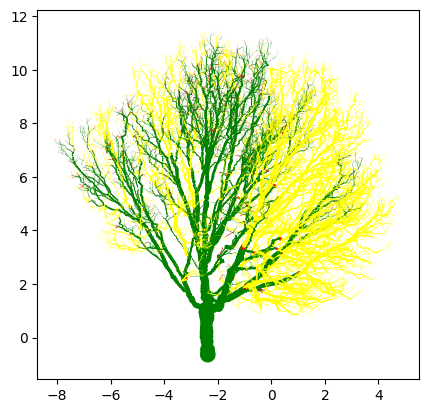

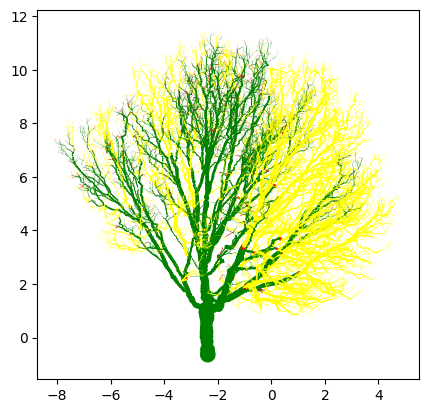

In [6]:
# cyls create by file
# fileNames = read_file_names()
cyls = []
# for f in fileNames:
#     print(f)
# Secrest32-01_000000.csv ,Secrest16-14_000000.csv ,Secrest02-26_000000.csv ,Secrest10-08_000000.csv ,Secrest32-06_000000.csv 
#,Secrest24-07_000000.csv ,Secrest03-12_000000.csv ,SecrestTI-CO_000000.csv ,Secrest26-03_000000.csv ,Secrest27-05_000000.csv 
#,Secrest18-13_000000.csv ,Secrest07-32_000000.csv
# for f in fileNames:
#     print(f)
#(True,0),(False,0),(True,-2/6),(False,-2/6),(True,-5/6),(False,-5/6),(True,-7/6),(False,-7/6)#
idx =0
fileNames = read_file_names()
# ['Secrest02-26_000000.csv', 'Secrest02-30_000000.csv', 'Secrest03-12_000000.csv', 'Secrest07-32_000000.csv', 'Secrest08-24c_000000.csv', 'Secrest10-08_000000.csv', 'Secrest14-09_000000.csv', 'Secrest16-3TI-CO_000000.csv', 'Secrest16-14LI-ST_000000.csv', 'Secrest18-13_000000.csv', 'Secrest23-23_000000.csv', 'Secrest24-03_000000.csv', 'Secrest04-19_000000.csv', 'Secrest10-02_000000.csv', 'Secrest11-27_000000.csv']

for f in fileNames:
    for id,vals in enumerate([(True,-2/6)#,(True,-2/6)#,(False,-2/6),(True,-10/6),(False,-10/6)
                            ]):
        #f= 'C:/Users/wisch/Documents/GitProjects/cylinders_personal/input/Secrest11-27_000000.csv'
        if 1==1: #try:
            c = CylinderCollection(f)
            cyls.append(c)
            cyls[idx].read_csv(rev=vals[0])

            cyls[idx].project_cylinders()
            # print(str(idx)+' cyls ')
            # # print('cyls projected ')

            # # #print('PlotAttempt')
            cyls[idx].create_wdgraph()
            # print(str(idx)+' graphed ')
        
            cyls[idx].find_flows(inFlowGradeLim=(vals[1]))
            # print(str(idx)+' flows found ')
            cyls[idx].highlight_drips()

            # cyls[idx].aggregate_drips() 
            # print('drips agged ')

            # cyls[idx].find_watershed_boundary()
            # print('alpha shape found ')
            
            # cyls[idx].nondrip_stats()
            cyls[idx].highlight_drips()

            # print(str(idx) + ' complete')

            
        # except:
            # print('error on file ' + f)
        idx+=1


    
    # cyls[idx].dripTotal['label']= 'drip'
    # cyls[idx].stemTotal['label']= 'stem'
    # cyls[idx].treeQualities['label']= 'stem'
    # cyls[idx].dripTotal['file']= cyls[idx].filename
    # cyls[idx].stemTotal['file']= cyls[idx].filename
    # # cyls[idx].treeQualities['file']= cyls[idx].filename
    # flows  = pd.concat([cyls[idx].dripTotal,cyls[idx].stemTotal], ignore_index=True, axis=0)
    # with pd.ExcelWriter('output.xlsx',
    #                     mode='a') as writer:  
    # to_write_flows =to_write_flows.append(flows)
    # to_write_stats = to_write_stats.append(cyls[idx].treeQualities)
    
    # to_write_flows.to_excel(cyls[0].filename + 'StemOutput.xlsx', sheet_name='Drip and stem')
    # to_write_stats.to_excel(cyls[0].filename + 'Stats_output.xlsx', sheet_name='stats')
    # with pd.ExcelWriter(cyls[idx].output_dir + str('/StemOutput.xlsx'), engine = 'openpyxl',mode='a',if_sheet_exists='overlay') as writer:
    #     flows.to_excel(writer, index = False, sheet_name ='Drip and stem')
    # with pd.ExcelWriter(cyls[idx].output_dir + str('/StatsOutput.xlsx'), engine = 'openpyxl',mode='a',if_sheet_exists='overlay') as writer:
    #     flows.to_excel(writer, index = False, sheet_name ='Drip and stem')


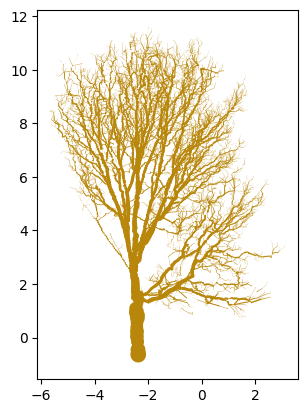

In [37]:


def highlight_drips(self,compID = -1):
        g=self.graph   
        drip_color= 'goldenrod'
        stem_color = 'darkgoldenrod'
        myPolys = []
        StemPolys = []
        DividePolys = []
        myColors=[]
        nodes= list(self.compGraphs[0].nodes())
        if compID ==-1:
            nodes = g.nodes()
        else:
            i=1
            while i < compID:
                for n in self.compGraphs[i].nodes():
                    nodes.append(n)
                i+=1
        filt_nodes = list(nodes) 

        curr_col = 'Yellow'
        prev=0
        for idx,n in enumerate(nodes):
            if idx+1 <= len(filt_nodes): parent = self.pID[n-1]+1
            if n in filt_nodes and n>0 and n<17000: 
                if g.edges[parent,n]['flowType'] =='stem': 
                      curr_col =stem_color
                      StemPolys.append(self.pSV[n-1])
                      if nx.degree(g,n) ==1: #if edge is an end node of the branch
                          #print('new Code fired')
                          curr_col = stem_color
                          DividePolys.append(self.pSV[n-1])
                if g.edges[parent,n]['flowType'] =='drip':
                    if self.BO[n] >0 and curr_col ==stem_color :
                        curr_col = stem_color
                        DividePolys.append(self.pSV[prev-1])
                    else: 
                        curr_col =drip_color
            if n<17000 and 1==1: # curr_col =='green' or curr_col == 'red':
                myColors.append(curr_col)
                myPolys.append(self.pSV[n-1])
            prev=n
    
        #plot All polys color coded  
        fig = plt.figure()
        ax = fig.add_subplot() 
        geoPolys =geo.GeoSeries(myPolys)
        
        plt.rcParams.update({
            "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
            "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
            "axes.facecolor":    (0.0, 0.0, 1.0, 0),  # green with alpha = 50%
            "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),  # blue  with alpha = 20%
        })

        geoPolys.plot(ax =ax,color=myColors)
        plt.show()
        if self.rev :
            self.save_file(method = 'highlight_drips' )    
        else: 
            self.save_file(method = 'highlight_drips' )    
        plt.close() 

highlight_drips(cyls[0],-1)



In [ ]:
def save_file(self, toWrite = [], subdir:str = 'agg', fileFormat ='.png',method=''):
        proj = 'XY'
        if self.rev : 
            proj='XZ'
        file_arr = os.path.splitext(os.path.basename(self.filename))
        dir = '/'.join([self.output_dir, method, '']).replace('/','\\')
        ofname = '_'.join([file_arr[0], method, proj , fileFormat ]).replace('/','\\')
        folderExists = os.path.exists(dir)
        fileExists = os.path.exists(dir+ofname)
        if not folderExists:
            os.makedirs(dir)
        if fileFormat =='.png': 
            plt.savefig(dir+ofname, format='png', dpi=1200)
        elif not fileExists:
            with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                toWrite.to_excel(writer, index = False, sheet_name =method)
        else:
            exist = pd.read_excel(open(dir+ofname, 'rb'), sheet_name=method, engine = 'openpyxl')  
            toWrite = toWrite.append(exist)
            with pd.ExcelWriter(dir + ofname, engine = 'openpyxl',mode='w') as writer:
                toWrite.to_excel(writer, index = False, sheet_name =method)
c = cyls[0]
DividePolys =c.dividePolys 
stemPolys = c.stem_polys 

DivideCentroids = [x.point_on_surface() for x in DividePolys]
hull, edge_points = concave_hull(DivideCentroids, alpha = 2.2)
fig = plt.figure()
ax = fig.add_subplot() 
geoPolys =geo.GeoSeries(myPolys)
geoPolys.plot(ax =ax)  

save_file(cyls[0],method = 'watershed' )

In [ ]:
# count flows

# zeros= []
# ones= []
# others = []
# for edge in cyls[0].graph.edges():
#     if g.edges[edge]['flowID'] ==0 : zeros.append(edge)
#     elif g.edges[edge]['flowID'] ==1 : ones.append(edge)
#     else : others.append(edge)

#count flows by type
# stemcnt=0
# dripcnt=0
# nan=0
# for n,type in g.nodes.data('flowType'):
#     if type =='drip': dripcnt+=1
#     elif type =='stem': stemcnt+=1
#     else: nan+=1

# print((stemcnt,dripcnt,nan))


print((len(zeros),len(ones),len(others)))

In [ ]:
#DBH
c = cyls[0]
bo=0
trunk_ids = []
colors = ['Blue']*len(c.pSV)
rev_polys =['']*len(c.pSV)
ids = []
i=0
for idx, bo_i in enumerate(c.BO):
    if bo_i==bo: 
        ids.append(idx)
        i+=1
        trunk_ids.append(idx)
        colors[-idx] = 'Red'
        #polys.append(c.pSV[idx])
    else:
        colors[-idx] ='None'
    rev_polys[-idx] = c.pSV[idx]

for id in trunk_ids:
    print(id)
    print('z[0,id]' + str(c.y[0,id]))
    print('z[1,id]' + str(c.y[1,id]))
    if c.y[0,id] >=4.5:
        dbh = c.radius[id]
        print(id)
        print(c.y[0,id])
        print(c.radius[id])
        break




In [ ]:
# len(cyls)
cyls[1].find_watershed_boundary()

In [ ]:
# import unittest

# class TestFlowAlgorithm(unittest.TestCase):
    # def test_upper(self):
        
    #     self.assertEqual('foo'.upper(), 'FOO')

    # def test_isupper(self):
    #     self.assertTrue('FOO'.isupper())
    #     self.assertFalse('Foo'.isupper())

    # def test_split(self):
    #     s = 'hello world'
    #     self.assertEqual(s.split(), ['hello', 'world'])
    #     # check that s.split fails when the separator is not a string
    #     with self.assertRaises(TypeError):
    #         s.split(2)

# if __name__ == '__main__':
#     unittest.main() 
test_case_cyls = []

def prepare_case(file_name = '1_HappyPathWTrunk.csv'):    
   # file_name
    df = pd.read_csv(file_name,header=0)
    test_cyls = df.iloc[:,1]
    print(test_cyls)
    # c = CylinderCollection(f)
    # test_case_cyls.append(c)
    # test_case_cyls[0].read_csv(rev=False)
    # test_case_cyls[0].project_cylinders()
   
    # print('cyls projected ')

    # test_case_cyls[0].create_wdgraph()
    # print(' graphed ')
    # test_case_cyls[0].find_flows(inFlowGradeLim=-2/6)
    # #cyls[idx].highlight_drips()
    # print(' flows found ')
    # plt.show()

    # # #c.highlight_branch_order(bo=0)
    # # print('drips highlighted ')

    # test_case_cyls[0].aggregate_drips()
    # print('drips aggregated ')

    # print(' complete')

file_name = '1_HappyPathWTrunk.csv'
df = pd.read_csv(file_name,header=0)
test_cyls = df.iloc[:,1]

gr = cyls[4].graph
gfilt = copy.deepcopy(nx.induced_subgraph(gr,test_cyls))  

for edge in gfilt.edges:
    print(edge)




In [ ]:
# Pulling statistics from the drip points graphs 
c= cyls[7]
g=c.graph
nodes = g.nodes().data("flowType")
# edges = g.edges().data("flowType")

dripTotal = pd.DataFrame(columns=['cyls','len','sa','pa','as'], index=[0])
stemTotal = pd.DataFrame(columns=['cyls','len','sa','pa','as'], index=[0])
stemCnt = 0
dripCnt = 0
for n,t in nodes:
    if flow =='stem': 
        dripTotal.iloc[0] = dripTotal.iloc[0] +g.nodes[v]['terminal_flow_total']
        dripCnt+=1
    elif g.edges[u,v]['flowType'] =='drip': 
        stemTotal.iloc[0] = stemTotal.iloc[0] +g.nodes[v]['terminal_flow_total']
        stemCnt+=1
    percentDrip = dripTotal/stemTotal
    print('percentDrip' + str(percentDrip))
    print('stemCnt' + str(stemCnt))
    print('dripCnt' + str(dripCnt))

In [ ]:
#file location testing
cyls[0].highlight_drips(10)
# def save_comp(comp_ID):
def save_figure( path=''.join([DIR,'/data']),fileFormat ='png',method=''):
        proj = 'XY'
        if True : proj='XZ'
        file = ''.join(['Secrest07-32_000000.csv'.replace('.csv',''),'_',method,'_',proj,'.',fileFormat])
        path = 'C:/Users/wisch/Documents/GitProjects/cylinders_personal/data/'
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path)
        plt.savefig(''.join([path,file]), format=fileFormat, dpi=1200)
save_figure(method = 'method')

# import csv  

# data = ['Afghanistan', 652090, 'AF', 'AFG']
# filePath = 'C:/Users/wisch/Documents/GitProjects/cylinders_personal/data/'
# isExist = os.path.exists(filePath)
# if not isExist:
#    os.makedirs(filePath)
# with open(''.join([filePath,'countries.csv']), 'w', encoding='UTF8') as f:
#     writer = csv.writer(f)

#     # write the data
#     writer.writerow(data)



In [ ]:
#Finding the unoverlapped area for each comp (Slow)
# c= cyls[0]
# compGraphs =[g for g in compGraphs] # the list of generated subgraphs from our connected components 
# compPolys = []
# for f in compGraphs:
#     polys = []
#     for n in f.nodes:
#         polys.append(c.pSV[n])
# #     compPolys.append(polys)
# exposed_projected_area = []
# total_projected_area = []
# for i,x in enumerate(compPolys):
#     #Combined all other branches (And the trunk) into one shape and compute
#     #the overlap between the two
#     otherPolys = unary_union([unary_union(x) for idx,x in enumerate(compPolys) if idx!=i])
#     currPoly = unary_union(x)
#     currPoly_gs = geo.GeoDataFrame(geometry =  geo.GeoSeries(currPoly))
#     other_gs = geo.GeoDataFrame( geometry = geo.GeoSeries(otherPolys))
#     overlay = geo.overlay(other_gs, currPoly_gs, how= 'intersection')
#     tpa = currPoly_gs.area
#     oa = overlay.area
#     exposed_projected_area.append(tpa-oa)
#     total_projected_area.append(tpa)
    
# print(exposed_projected_area)
    




# #testing code for printing out a single overlap
# otherPolys = unary_union([unary_union(x) for i,x in enumerate(compPolys) if i!=6])

# myPolys_gs = geo.GeoSeries(unary_union(compPolys[6]))
# others_gs = geo.GeoSeries(otherPolys)
# myPolys = geo.GeoDataFrame(geometry = myPolys_gs)

# overlay = geo.overlay(others, myPolys, how= 'intersection')
# print(overlay.area)
# print(myPolys_gs.area)
# print(others_gs.area)

others = geo.GeoDataFrame( geometry = c.pSV)
toClip = geo.GeoDataFrame( geometry = c.pSV[0])

clipped = others.clip(toClip)


# print(len(others))
# print(len(clipped))

# fig, ax = plt.subplots(figsize = (20,16))
# others.plot(ax=ax,alpha=.5)
# clipped.plot(alpha=.5)
# plt.ion()
# plt.show() 

# fig, ax = plt.subplots(figsize = (20,16)) 
# myPolys = geo.GeoSeries(compPolys[6])
# others = geo.GeoSeries(otherPolys)
# others.plot(ax=ax,alpha=.5)
# myPolys.plot(ax=ax,alpha=.5)
 
       
# plt.ion()
# plt.show() 

In [ ]:
#Digraph Create Code
c=cyls[1]
R = {}
sid = c.df[' ID']
pid = c.df[' parentID']
sid.min()
sid = sid + 1
pid = pid + 1
    
#adjacency matrix construction from ID and parent ID#find unique ID and parent ID values#depending on what values exist, translate to a range compatible with square matrix indicies#For each segment ID and corresponding parent ID, fill element in square matrix#end
    
noSeg = np.max(sid) + 2
A = np.zeros((noSeg,noSeg))
attr = []
gr = nx.DiGraph()
for idx in range(noSeg-3):
    print(idx)
    #from row to column
    child =sid[idx]
    par = pid[idx]
    attr={"length" : c.df.iloc[pid[idx], 12],
            "bheight": c.df.iloc[pid[idx], 5],
            "eheight": c.df.iloc[pid[idx], 8],
            "radius": c.df.iloc[pid[idx], 9],
            "aV": c.aV[pid[idx]],
            "bV": c.bV[pid[idx]]
            }
    gr.add_edge(child,par,attr_dict =attr)
rows, cols = np.where(A == 1)



In [ ]:
#Building stem_path objects
from stemPath import StemPath
c= cyls[0]
gr =c.graph
stemPaths = []
#sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
sp = nx.shortest_path(gr,target=0, weight ='get_height')
#print([e for e in gr.nodes if gr.degree(e)==1])
endnodes = [e for e in gr.nodes if gr.degree(e)==1]
color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
#print(len(endnodes))
#print(gr.edges[1,0]['attr_dict']['eheight'])
for path in sp.values():
    pathLen = len(path)
    s = StemPath(c.filename)
    #x =np.arange(0,pathLen-1)
    if (path[0] in endnodes)and pathLen>2:
        s.nodes=path
        temp_attr_dict = []
        for idx,v in enumerate(path):
            if idx+1!=pathLen:
                u = path[idx+1]
                temp_attr_dict.append(gr.edges[v,u]['attr_dict'])
        s.attr_dict=temp_attr_dict
        stemPaths.append(s)



In [ ]:
# draw branchs of specified branch order
trunk_ids = []
colors = ['']*len(c.pSV)
polys = []
rev_polys =['']*len(c.pSV)


for idx, bo in enumerate(c.BO):
    if bo == 1: 
        trunk_ids.append(idx)
        colors[-idx] = 'Red'
        #polys.append(c.pSV[idx])
    else:
        colors[-idx] ='None'
    rev_polys[-idx] = c.pSV[idx]

#myPolys = geo.GeoSeries(polys)
#myPolys.plot(color='red')

fig, ax = plt.subplots(figsize = (20,16)) 
myPolys = geo.GeoSeries(rev_polys)
myPolys.plot(color=colors,ax=ax, alpha = .5)
#myPolys.plot()
plt.savefig(str(c.filename).replace('.csv','') +str("_output.svg"), format='svg', dpi=1200)
        
plt.ion()
plt.show()


In [ ]:
#Identifying trunkNodes
import copy
gr= cyls[0].graph 
gtest = copy.deepcopy(gr)
print(gtest.number_of_nodes())
trunkNodes =  np.where(c.BO == 0)[0]

# pull connected components and create graphs 
#c.create_graph()
c=cyls[0]
gtest = copy.deepcopy(c.graph)
print(nx.number_connected_components(gtest))
gtest.remove_nodes_from(trunkNodes)
print(nx.number_connected_components(gtest))

nt_comps = nx.connected_components(gtest)

compGraphs = [gtest.subgraph(c).copy() for c in nt_comps]

gr= cyls[1].graph 
gtest_xz = copy.deepcopy(gr)
print(gtest_xz.number_of_nodes())
trunkNodes_xz =  np.where(c.BO == 0)[0]

c=cyls[1]
gtest_xz= copy.deepcopy(c.graph)
print(nx.number_connected_components(gtest_xz))
gtest_xz.remove_nodes_from(trunkNodes_xz)
print(nx.number_connected_components(gtest_xz))

nt_comps_xz = nx.connected_components(gtest_xz)

compGraphs_xz = [gtest_xz.subgraph(c).copy() for c in nt_comps_xz]





In [ ]:
#Finding the unoverlapped area for each comp (Slow)
# c= cyls[0]
# compGraphs =[g for g in compGraphs] # the list of generated subgraphs from our connected components 
# compPolys = []
# for f in compGraphs:
#     polys = []
#     for n in f.nodes:
#         polys.append(c.pSV[n])
# #     compPolys.append(polys)
# exposed_projected_area = []
# total_projected_area = []
# for i,x in enumerate(compPolys):
#     #Combined all other branches (And the trunk) into one shape and compute
#     #the overlap between the two
#     otherPolys = unary_union([unary_union(x) for idx,x in enumerate(compPolys) if idx!=i])
#     currPoly = unary_union(x)
#     currPoly_gs = geo.GeoDataFrame(geometry =  geo.GeoSeries(currPoly))
#     other_gs = geo.GeoDataFrame( geometry = geo.GeoSeries(otherPolys))
#     overlay = geo.overlay(other_gs, currPoly_gs, how= 'intersection')
#     tpa = currPoly_gs.area
#     oa = overlay.area
#     exposed_projected_area.append(tpa-oa)
#     total_projected_area.append(tpa)
    
# print(exposed_projected_area)
    




# #testing code for printing out a single overlap
# otherPolys = unary_union([unary_union(x) for i,x in enumerate(compPolys) if i!=6])

# myPolys_gs = geo.GeoSeries(unary_union(compPolys[6]))
# others_gs = geo.GeoSeries(otherPolys)
# myPolys = geo.GeoDataFrame(geometry = myPolys_gs)

# overlay = geo.overlay(others, myPolys, how= 'intersection')
# print(overlay.area)
# print(myPolys_gs.area)
# print(others_gs.area)

others = geo.GeoDataFrame( geometry = c.pSV)
toClip = geo.GeoDataFrame( geometry = c.pSV[0])

clipped = others.clip(toClip)


# print(len(others))
# print(len(clipped))

# fig, ax = plt.subplots(figsize = (20,16))
# others.plot(ax=ax,alpha=.5)
# clipped.plot(alpha=.5)
# plt.ion()
# plt.show() 

# fig, ax = plt.subplots(figsize = (20,16)) 
# myPolys = geo.GeoSeries(compPolys[6])
# others = geo.GeoSeries(otherPolys)
# others.plot(ax=ax,alpha=.5)
# myPolys.plot(ax=ax,alpha=.5)
 
       
# plt.ion()
# plt.show() 

In [ ]:
[len(comp.nodes()) for comp in compGraphs]

# compSize =[len(cc) for cc in nt_comps]

# for x in compSize:
#     print(x) """  """
# We have 68 connected components but 67 path groups?
#       must be the sement of length 1
#[1683, 1689, 952, 862, 6415, 2252, 2058, 506, 542, 467, 501, 21, 339, 1, 2984, 682, 59, 2, 2284, 2, 2, 324, 505, 329, 2, 2, 8, 2, 2, 30, 4, 231, 6, 288, 65, 158, 6, 2, 134, 11, 5, 240, 44, 2, 58, 39, 15, 12, 5, 3, 2, 2, 1, 1, 41, 11, 3, 2, 11, 3, 11, 7, 5, 3, 10, 3, 2, 1]


# print(len(compSize))
 
# print(len(sigComp))

# print(pd.DataFrame(compSize).describe())
#                  0
# count    68.000000
# mean    396.382353
# std     973.939178
# min       1.000000
# 25%       2.750000
# 50%      11.000000
# 75%     325.250000
# max    6415.000000
 

In [ ]:
# #Highlighting Drip Branches
cylId=1
#if 1==1:
  #print('test')
  # c= cyls[cylId]
  # g = c.graph  
  # trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
  # c.trunkNodes=trunkNodes 
  # print(trunkNodes)
  # trunk_edges=[]
  # prev_node=None
  # for n in trunkNodes:
  #   if prev_node !=None:
  #       trunk_edges.append((prev_node,n))
  #   prev_node = n
  # gtest = copy.deepcopy(g)
  # trunk_edges = []
  # #non_trunk_edges = [e for e in g.edges(trunkNodes) if e not in trunk_edges]
  # #print(gtest.number_of_nodes())    
  # gtest.remove_nodes_from(trunkNodes)  
  # #gtest.add_edges_from(non_trunk_edges)   
  # #print(nx.number_connected_components(gtest))
  # titans = [node for node in gtest.nodes if (nx.degree(g,node)!=nx.degree(gtest,node))]
  #     #Nodes with a parent node in trunk, only 1 per connected component
  # c.connComps = nx.connected_components(gtest)
  # compGraphs = [g.subgraph(comp).copy() for comp in c.connComps]
print(len(compGraphs))

compId = 28
c=cyls[cylId]
g=cyls[cylId].graph   
myPolys = []
compGraph = compGraphs[compId]
nodes = compGraph.nodes() # [n for n in compGraph.nodes if n not in trunkNodes]
filt_nodes = list(nodes) # [1065, 1064, 1063, 1049, 1048, 1047, 1006, 1005, 1004, 1003, 1002, 1001, 81]
myColors=[]#['blue']*len(filt_nodes)
curr_col='Blue'
for idx,n in enumerate(filt_nodes):
  if n in filt_nodes: 
    if idx+1 <= len(filt_nodes): 
      parent = c.pID[n-1]+1
    try:
      if g.edges[parent,n]['flowType'] =='stem': 
        curr_col ='Green'
      if g.edges[parent,n]['flowType'] =='drip': 
        curr_col ='Red'
    except:
      print('throw' + str((parent,n)))
    # print(idx)
    myColors.append(curr_col)
    # print(curr_col,(parent,n))
    myPolys.append(c.pSV[n-1])
    curr_col ='blue'
# print(nodes)
# print(myColors)
plt.figure(figsize=(10,10))
test =geo.GeoSeries(myPolys)
test.plot(color=myColors,figsize=(10,10))



# for n1,n2,type in compGraph.edges.data('flowType'):
#     print((n1,n2,type))
#     print(g.edges[n1,n2]['flowType'])


# comp 17 is questionable (flow lost due to very slight out flow)
# 23 is questionable but leans the other way towards valididty
# 24 i also questionable outflow over vertical section 
#26 has one questionable branch


In [ ]:
#Stacking tree and drip maps
# myPolys = []
# i=0
# while i<len(c.pSV):
#   myPolys.append(c.pSV[i])
#   i+=1

#myPolys.plot(color=colors,ax=ax, alpha = .5)


fig, ax = plt.subplots()    
# test =geo.GeoSeries(myPolys)
#test.plot(ax=ax,alpha=0.2)
# for row in myColors:
#     if row == 'Green': row = 'lightsteelblue'
#     if row == 'Red': row =='royalblue'
test.plot(color=myColors,figsize=(10,9),alpha=.1)

ax2 = ax.twinx()
ax3 = ax2.twinx()
plt.imshow(drip_loc, cmap='Blues',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y],label='drip')
#plt.imshow(drip_loc_trunk, cmap='Greys',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y] ,label='trunk')

#im1 =ax.imshow(drip_loc, cmap='Reds',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y] )
plt.ion()
plt.show()
plt.savefig(str(c.filename).replace('.csv','') +str('dripMapPlotWStem.svg'), format='svg', dpi=1200)



In [ ]:
#projected areas (exposed v. not)


c= cyls[0]
compPolys = []
compNodes = []
totalLengths = []
totalSAs = []
for f in compGraphs:
    polys = []
    nodes = []
    l=0
    r=0
    sa=0
    for n in f.nodes:
        nodes.append(n)
        polys.append(c.pSV[n])
        l +=c.cLength[n]
        r += c.radius[n]
    compPolys.append(polys)
    compNodes.append(n)


    
print(stemPaths[1].attr_dict[1]['length'])

TotalLengths = []
TotalVolume = []
TotalProjectedSurfaceAreas= []
for sp in stemPaths:
    sp.cyls = c
    length,SA,pSA = 0
    for idx, n in enumerate(sp.nodes):
        if idx<len(sp.nodes)-1:
            l =c.cLength[n]
            r = c.radius[n]
            length+=l
            p
            length+=c.cLength[n] 
            print((c.cLength[cylNum],stemPaths[1]))

# for Node n in our path (same as that in graph) 
# cyls.clength[n] = lenghth of nth cylinder
# Also the length of the edge n to n-1 
# 
# if n is in a path, cyl=[n] is in the path for all but last node
    otherPolys = unary_union([unary_union(x) for idx,x in enumerate(compPolys) if idx!=i])
    currPoly = unary_union(x)
    currPoly_gs = geo.GeoDataFrame(geometry =  geo.GeoSeries(currPoly))
    other_gs = geo.GeoDataFrame( geometry = geo.GeoSeries(otherPolys))
    overlay = geo.overlay(other_gs, currPoly_gs, how= 'intersection')
    tpa = currPoly_gs.area
    oa = overlay.area
    exposed_projected_area.append(tpa-oa)
    total_projected_area.append(tpa)

